In [1]:
from math import ceil
import string
import random
import pandas as pd
pd.set_option("max_rows", 999)

# Constructing a Simple 4 Rounds SPN Network
- Each S-Box for each round are the same across all the rounds

Initialize Variables for Simple SPN Network

In [ ]:
# 16 bits block size
BLOCK_SIZE = 16

# 4 bits S-Box size
SBOX_SIZE = 4

# if debug, print messages
DEBUG = False

## S-Box Implementation

In [ ]:
# Substitution map for encryption (key, value pair)
sbox_map = {0x0:0xE, 0x1:0x4, 0x2:0xD, 0x3:0x1, 0x4:0x2, 0x5:0xF, 0x6:0xB, 0x7:0x8, 0x8:0x3, 0x9:0xA, 0xA:0x6, 0xB:0xC, 0xC:0x5, 0xD:0x9, 0xE:0x0, 0xF:0x7}
# Substitution map for decryption (key, value pair)
sbox_inverse_map = {0xE:0x0, 0x4:0x1, 0xD:0x2, 0x1:0x3, 0x2:0x4, 0xF:0x5, 0xB:0x6, 0x8:0x7, 0x3:0x8, 0xA:0x9, 0x6:0xA, 0xC:0xB, 0x5:0xC, 0x9:0xD, 0x0:0xE, 0x7:0xF}

# function for encryption
def sbox_encrypt(state):
    # capture substates for 4 Sboxes for each round by taking first 4 bits, second 4 bits, third 4 bits and final 4 bits out of the 16 bits state
    subStates = [state&0x000f, (state&0x00f0)>>4, (state&0x0f00)>>8, (state&0xf000)>>12]
    for index in range(len(subStates)):
        subState = subStates[index]
        subStates[index] = sbox_map[subState]
    return subStates[0]|subStates[1]<<4|subStates[2]<<8|subStates[3]<<12

# function for decryption
def sbox_decrypt(state):
    # capture substates for 4 Sboxes for each round by taking first 4 bits, second 4 bits, third 4 bits and final 4 bits out of the 16 bits state
    subStates = [state&0x000f, (state&0x00f0)>>4, (state&0x0f00)>>8, (state&0xf000)>>12]
    for index in range(len(subStates)):
        subState = subStates[index]
        subStates[index] = sbox_inverse_map[subState]
    return subStates[0]|subStates[1]<<4|subStates[2]<<8|subStates[3]<<12

## P-Box Implementation

In [ ]:
# Permutation map. Applied bit-wise. Can be used for decryption and encryption
pbox_map = {0:0, 1:4, 2:8, 3:12, 4:1, 5:5, 6:9, 7:13, 8:2, 9:6, 10:10, 11:14, 12:3, 13:7, 14:11, 15:15}

# function for passing through a Pbox
def pbox(state):
    state_temp = 0      
    for bitIdx in range(0, BLOCK_SIZE):
        if(state & (1 << bitIdx)):
            state_temp |= (1 << pbox_map[bitIdx])
    return state_temp

## Key Scheduling Algorithm
- This algorithm is adapted from https://eprint.iacr.org/2020/1545

In [ ]:
# Returns a list of round keys
def key_scheduler_algo(master_key, num_rounds, alpha = 13, gamma = 8):
    keys = []
    master_key_bit_length = ceil(master_key.bit_length() / 4) * 4

    if master_key_bit_length < BLOCK_SIZE:
        print('Master key size has to be longer or the same size as the block size')
        return

    for i in range(1, num_rounds + 2):

        # Step 1: extract leftmost n bits as round keys (where n = BLOCK_SIZE)
        key_shift = master_key_bit_length - BLOCK_SIZE
        keys.append(master_key >> key_shift)
        if DEBUG:
            print(f'Round {i} Key: {hex(keys[i - 1])}')
        if i == num_rounds + 1:
            return hex( (keys[0]<<64) | (keys[1]<<48) | (keys[2]<<32) | (keys[3]<<16) | keys[4])

        # Step 2: rotate left by alpha
        key_shift = master_key_bit_length - alpha
        left = master_key & int('1' * key_shift, 2)
        right = master_key >> key_shift
        master_key = left << alpha ^ right
        if DEBUG:
            print(f'Round {i} After Step 2: {hex(master_key)}')

        # Step 3: process leftmost n bits with the n-bit S-Box
        key_shift = master_key_bit_length - SBOX_SIZE
        left = sbox_map[master_key >> key_shift]
        right = master_key & int('1' * key_shift, 2)
        master_key = left << key_shift ^ right
        if DEBUG:
            print(f'Round {i} After Step 3: {hex(master_key)}')

        # Step 4: XOR the round number with the master_key from position gamma to (gamma - 4)
        key_shift = gamma - 4
        master_key ^= i << key_shift
        if DEBUG:
            print(f'Round {i} After Step 4: {hex(master_key)}\n')

k = key_scheduler_algo(0x6FF91, 4)[2:]
print(f"Round Key #1: {k[0:4]}\n")
print(f"Round Key #2: {k[4:8]}\n")
print(f"Round Key #3: {k[8:12]}\n")
print(f"Round Key #4: {k[12:16]}\n")
print(f"Round Key #5: {k[16:20]}\n")

Round Key #1: 6ff9

Round Key #2: d2de

Round Key #3: 9fa7

Round Key #4: 773c

Round Key #5: 38ea



## Simple SPN Cipher Encryption

In [ ]:
def encrypt(pt, k):
    state = pt
    if DEBUG: print('Plaintext = {:04x}'.format(state))
    
    # Derive 5 round keys
    subKeys = [ int(subK, 16) for subK in [ k[0:4],k[4:8], k[8:12], k[12:16], k[16:20] ] ]
    
    # First three rounds of sinple SPN network
    for round in range(0, 3):
    
        if DEBUG: print('Round {:d}:'.format(round + 1), end = ' ')
        # XOR state with round key (1st, 2nd and 3rd round keys depending on which round)
        state = state ^ subKeys[round] # round keys mixing
        if DEBUG: print(hex(state), end = ' ')
        
        # Break state into nibbles, perform sbox on each nibble
        state = sbox_encrypt(state)
        if DEBUG: print(hex(state), end = ' ')
        
        # Permute the state bitwise
        state = pbox(state)
        if DEBUG: print(hex(state))
    
    # Final round of SPN cipher (4th round key, sbox, 5th round key)
    if DEBUG: print('Round 4:', end = ' ')
    state = state ^ subKeys[-2] # 4th round key mixing
    if DEBUG: print(hex(state), end = ' ')   
    state = sbox_encrypt(state)
    if DEBUG: print(hex(state), end = ' ')
    state = state ^ subKeys[-1] # Final round key mixing
    if DEBUG: print(hex(state)) 
    if DEBUG: print('Ciphertext = {:04x}\n\n'.format(state))
    
    return state

## Simple SPN Cipher Decryption

In [ ]:
def decrypt(ct, k):
    state = ct
    if DEBUG: print('Ciphertext = {:04x}'.format(state))
    
    # Derive 5 round keys
    subKeys = [ int(subK,16) for subK in [ k[0:4],k[4:8], k[8:12], k[12:16], k[16:20] ] ]
    
    # Undo final round key
    if DEBUG: print('Undo Round 4:', end = ' ')
    state = state^subKeys[4]
    if DEBUG: print (hex(state), end= ' ')
    
    # Apply inverse sbox
    state = sbox_decrypt(state)
    if DEBUG: print (hex(state), end= ' ')

    # Undo 2nd last round key
    state = state^subKeys[3]
    if DEBUG: print (hex(state))
    
    #Undo first 3 rounds of simple SPN cipher
    for round in range(2, -1, -1):
        
        if DEBUG: print('Undo Round {:d}:'.format(round + 1), end = ' ')
        # Un-permute the state bitwise
        state = pbox(state)
        if DEBUG: print (hex(state), end = ' ')
        
        # Break state into nibbles, perform inverse sbox on each nibble
        state = sbox_decrypt(state)
        if DEBUG: print (hex(state), end=' ')

        # XOR state with round key (1st, 2nd and 3rd round keys depending on which round)
        state = state^subKeys[round]
        if DEBUG: print (hex(state))
    
    if DEBUG: print('Plaintext = {:04x}\n\n'.format(state))     
     
    return state

# Generating n Pairs of (plaintext, ciphertext)

In [ ]:
#Generate a maximum of 50,000 random plaintext-ciphertext pairs for linear cryptanalysis
num_of_plaintext_ciphertext_pairs = 50000

def generate_plaintext_ciphertext_pairs(num_of_plaintext_ciphertext_pairs):
    plaintext_array = []
    ciphertext_array = []
    plaintext_array = random.sample(range(1, 65535), num_of_plaintext_ciphertext_pairs)

    for i in range(0, num_of_plaintext_ciphertext_pairs):
        ciphertext = encrypt(plaintext_array[i], k)
        ciphertext_array.append(ciphertext)

    # Produce a CSV of plaintext, ciphertext value pairs for cryptanalysis
    if (DEBUG):
        df = pd.DataFrame.from_dict({'plaintext': plaintext_array, 'ciphertext': ciphertext_array})
        filename = 'sample_data/' + k[0:20] + '.csv'
        df.to_csv(index=False, path_or_buf=filename)

    return plaintext_array, ciphertext_array

plaintext_array, ciphertext_array = generate_plaintext_ciphertext_pairs(num_of_plaintext_ciphertext_pairs)

# Linear Cryptanalysis

In [ ]:
# calculate the bias of the linear approximation using Piling-Up Lemma Eqn
def piling_up_lemma(bias_list):
    mul_bias = bias_list[0]
    n = len(bias_list)
    for i in range(1, n):
        mul_bias *= bias_list[i]
    return 2 ** (n - 1) * mul_bias

In [ ]:
def generate_linear_approximation_table():
    # set up linear approximation table
    linear_approximation_table = [[0 for x in range(BLOCK_SIZE)] for y in range(BLOCK_SIZE)]

    # populate the linear approximation table
    for i in range(0, BLOCK_SIZE):
        for j in range(0, BLOCK_SIZE):
            count = 0
            for key, val in sbox_map.items():
                xor_sum = 0
                sbox_input = key & i
                sbox_output = val & j
                while (sbox_input > 0):
                    xor_sum ^= sbox_input & 1
                    sbox_input >>= 1
                while (sbox_output > 0):
                    xor_sum ^= sbox_output & 1
                    sbox_output >>= 1
                if xor_sum == 0:
                    count += 1
            linear_approximation_table[i][j] = count - 8
    
    # generate the complete enumeration of all linear approximation of the S-Box in our cipher
    headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F"]
    linear_approximation_table_df = pd.DataFrame(linear_approximation_table, headers, headers)
    display(linear_approximation_table_df)

generate_linear_approximation_table()

,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F
0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,-2,-2,0,0,-2,6,2,2,0,0,2,2,0,0
2,0,0,-2,-2,0,0,-2,-2,0,0,2,2,0,0,-6,2
3,0,0,0,0,0,0,0,0,2,-6,-2,-2,2,2,-2,-2
4,0,2,0,-2,-2,-4,-2,0,0,-2,0,2,2,-4,2,0
5,0,-2,-2,0,-2,0,4,2,-2,0,-4,2,0,-2,-2,0
6,0,2,-2,4,2,0,0,2,0,-2,2,4,-2,0,0,-2
7,0,-2,0,2,2,-4,2,0,-2,0,2,0,4,2,0,2
8,0,0,0,0,0,0,0,0,-2,2,2,-2,2,-2,-2,-6
9,0,0,-2,-2,0,0,-2,-2,-4,0,-2,2,0,4,2,-2


**Linear Approximations of SPN**

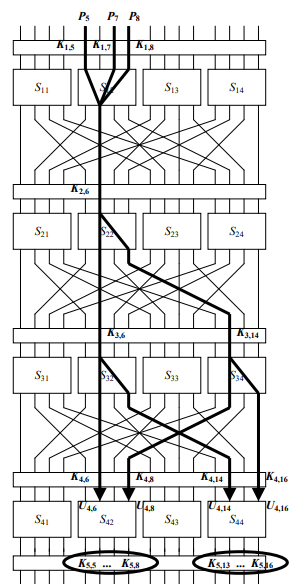

$S_{12}: X_{1} + X_{3} + X_{4} = Y_{2}$ with probability 12/16 and bias +1/4<br>
$S_{22}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>
$S_{32}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>
$S_{34}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>

*Combining the Equations:*<br>
$U_(4,6) \bigoplus U_{4,8} \bigoplus U_{4,14} \bigoplus U_{4,16} \bigoplus P_{5} \bigoplus P_{7} \bigoplus P_{8} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher
 
$U_{i}$: represent the 16-bit block of bits at the input of the round i S-boxes<br>
$V_{i}$: represent the 16-bit block of bits at the output of the round i S-boxes<br>
$U_{i,j}$: represent the j-th bit of block $U_{i}$<br> 
$V_{i,j}$: represent the j-th bit of block $V_{i}$<br> 

**Note**: j is between 1 to 16 (inclusive)

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([0.25, -0.25, -0.25, -0.25])))

Bias of Linear Approximation: -0.03125


In [ ]:
# linear approximation affects the inputs to S-Boxes S(4, 2) and S(4, 4) in the last round
# for each plaintext/ciphertext pair, try all 2^8 = 256 values for the target partial subkey [K(5, 5)...K(5,8), K(5, 13)...K(5, 16)]

def decrypt_s42(ciphertext, k55_k58):
    c55_c58 = (ciphertext & 0x0f00) >> 8
    v45_v48 = c55_c58 ^ k55_k58
    return sbox_inverse_map[v45_v48]
    
def decrypt_s44(ciphertext, k513_k516):
    c513_c516 = ciphertext & 0x000f
    v413_v416 = c513_c516 ^ k513_k516
    return sbox_inverse_map[v413_v416]

In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.
num_of_possible_keys = 2 ** 8
# num_of_plain_cipher_pairs = len(df)
num_of_plain_cipher_pairs = 10000
key_list = []
bias_list = []

for key in range(num_of_possible_keys):
    #print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]
        
        k55_k58 = (key & 0xf0) >> 4
        k513_k516 = key & 0x0f
        
        u45_u48 = decrypt_s42(ciphertext, k55_k58)
        u413_u416 = decrypt_s44(ciphertext, k513_k516)
        
        u46 = (u45_u48 & 0x4) >> 2
        u48 = u45_u48 & 0x1
        u414 = (u413_u416 & 0x4) >> 2
        u416 = u413_u416 & 0x1
        p5 = (plaintext & 0x0800) >> 11
        p7 = (plaintext & 0x0200) >> 9
        p8 = (plaintext & 0x0100) >> 8
        
        xor_all = u46 ^ u48 ^ u414 ^ u416 ^ p5 ^ p7 ^ p8
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df

,key,bias
0,0,0.0057
1,1,0.0039
2,2,0.0049
3,3,0.0109
4,4,0.0062
5,5,0.0067
6,6,0.0074
7,7,0.0101
8,8,0.0035
9,9,0.0062


In [ ]:
# extract key with the highest bias
row_num = result_df['bias'].argmax()
subkey_5 = result_df.loc[[row_num]]['key'].item()
subkey_55_58 = (subkey_5 & 0xf0) >> 4
subkey_513_516 = subkey_5 & 0x0f

print (f"Actual Final Round key: {k[16:20]}\n")
print (f"Partial Subkey 5_5 to 5_8: {hex(subkey_55_58)}")
print (f"Partial Subkey 5_13 to 5_16: {hex(subkey_513_516)}")

Actual Final Round key: 38ea

Partial Subkey 5_5 to 5_8: 0x8
Partial Subkey 5_13 to 5_16: 0xa


**New Linear Approximations of SPN**

**For the purpose of capturing partial subkey bits for K1...K4, K9...K12**

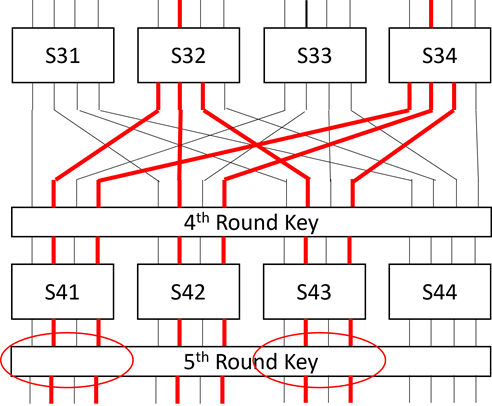

$S_{12}: X_{1} + X_{3} + X_{4} = Y_{2}$ with probability 12/16 and bias +1/4<br>
$S_{22}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>
$S_{32}: X_{2} = Y_{1} + Y_{2} + Y_{3}$ with probability 10/16 and bias +1/8<br>
$S_{34}: X_{2} = Y_{1} + Y_{2} + Y_{3}$ with probability 10/16 and bias +1/8<br>

*Combining the Equations:*<br>
$U_{4,2} \bigoplus U_{4,4} \bigoplus U_{4,6} \bigoplus U_{4,8} \bigoplus U_{4,10} \bigoplus U_{4,12} \bigoplus P_{5} \bigoplus P_{7} \bigoplus P_{8} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher
 
$U_{i}$: represent the 16-bit block of bits at the input of the round i S-boxes<br>
$V_{i}$: represent the 16-bit block of bits at the output of the round i S-boxes<br>
$U_{i,j}$: represent the j-th bit of block $U_{i}$<br> 
$V_{i,j}$: represent the j-th bit of block $V_{i}$<br> 

**Note**: j is between 1 to 16 (inclusive)

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([0.25, -0.25, +0.125, +0.125])))

Bias of Linear Approximation: -0.0078125


In [ ]:
# linear approximation affects the inputs to S-Boxes S(4, 2) and S(4, 4) in the last round
# for each plaintext/ciphertext pair, try all 2^8 = 256 values for the target partial subkey [K(5, 1)...K(5,4), K(5, 9)...K(5, 12)]
# From previous linear approximations, subkey [K(5, 1)...K(5,4)] is already obtained

def decrypt_s41(ciphertext, k51_k54):
    c51_c54 = (ciphertext & 0xf000) >> 12
    v41_v44 = c51_c54 ^ k51_k54
    return sbox_inverse_map[v41_v44]
    
def decrypt_s43(ciphertext, k59_k512):
    c59_c512 = (ciphertext & 0x00f0) >> 4
    v49_v412 = c59_c512 ^ k59_k512
    return sbox_inverse_map[v49_v412]

In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.
num_of_possible_keys = 2 ** 8
# num_of_plain_cipher_pairs = len(df)
num_of_plain_cipher_pairs = 20000
key_list = []
bias_list = []

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]
        
        k51_k54 = (key & 0xf0) >> 4
        k59_k512 = key & 0x0f
        
        u41_u44 = decrypt_s41(ciphertext, k51_k54)
        u45_u48 = decrypt_s42(ciphertext, subkey_55_58)
        u49_u412 = decrypt_s43(ciphertext, k59_k512)
        
        u42 = (u41_u44 & 0x4) >> 2
        u44 = u41_u44 & 0x1
        u46 = (u45_u48 & 0x4) >> 2
        u48 = u45_u48 & 0x1
        u410 = (u49_u412 & 0x4) >> 2
        u412 = u49_u412 & 0x1
        p5 = (plaintext & 0x0800) >> 11
        p7 = (plaintext & 0x0200) >> 9
        p8 = (plaintext & 0x0100) >> 8
        
        xor_all = u42 ^ u44 ^ u46 ^ u48 ^ u410 ^ u412 ^ p5 ^ p7 ^ p8
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
pd.set_option('max_rows', 9999)
result_df = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.00130
1,1,0.00290
2,2,0.00025
3,3,0.00600
4,4,0.00500
5,5,0.00000
6,6,0.00455
7,7,0.00380
8,8,0.00825
9,9,0.00010


In [ ]:
# extract key with the highest bias
row_num = result_df['bias'].argmax()
subkey_5 = result_df.loc[[row_num]]['key'].item()
subkey_51_54 = (subkey_5 & 0xf0) >> 4
subkey_59_512 = subkey_5 & 0x0f
round_key_5 = subkey_51_54 << 12 | subkey_55_58 << 8 | subkey_59_512 << 4 | subkey_513_516

print (f"Actual Final Round key: {k[16:20]}\n")
print (f"Partial Subkey 5_1 to 5_4: {hex(subkey_51_54)}")
print (f"Partial Subkey 5_5 to 5_8: {hex(subkey_55_58)}")
print (f"Partial Subkey 5_9 to 5_12: {hex(subkey_59_512)}")
print (f"Partial Subkey 5_13 to 5_16: {hex(subkey_513_516)}")
print (f"Obtained Final Round key: {hex(round_key_5)}\n")

Actual Final Round key: 38ea

Partial Subkey 5_1 to 5_4: 0x3
Partial Subkey 5_5 to 5_8: 0x8
Partial Subkey 5_9 to 5_12: 0xe
Partial Subkey 5_13 to 5_16: 0xa
Obtained Final Round key: 0x38ea



# Getting 4th Round Key

$S_{12}: X_{1} + X_{3} + X_{4} = Y_{2}$ with probability 12/16 and bias +1/4<br>
$S_{22}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>

*Combining the Equations:*<br>
$U_{3,6} \bigoplus U_{3,14} \bigoplus P_{5} \bigoplus P_{7} \bigoplus P_{8} \bigoplus \sum{k} = 0$<br>

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([0.25, -0.25])))

Bias of Linear Approximation: -0.125


In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 1000
key_list = []
bias_list = []

def decrypt_s32(c41_c44, c45_c48, c49_c12, c413_c416):
    c4 = c41_c44 << 12 | c45_c48 << 8 | c49_c12 << 4 | c413_c416
    v3 = pbox(c4)
    v35_v38 = (v3 & 0x0f00) >> 8
    return sbox_inverse_map[v35_v38]

def decrypt_s34(c41_c44, c45_c48, c49_c12, c413_c416):
    c4 = c41_c44 << 12 | c45_c48 << 8 | c49_c12 << 4 | c413_c416
    v3 = pbox(c4)
    v313_v316 = v3 & 0x000f
    return sbox_inverse_map[v313_v316]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u41_u44 = decrypt_s41(ciphertext, subkey_51_54)
        u45_u48 = decrypt_s42(ciphertext, subkey_55_58)
        u419_u412 = decrypt_s43(ciphertext, subkey_59_512)
        u413_u416 = decrypt_s44(ciphertext, subkey_513_516)

        k41_k44 = 0 << 3 | (key & 0x80) >> 5 | 0 << 1 | (key & 0x40) >> 6
        k45_k48 = 0 << 3 | (key & 0x20) >> 3 | 0 << 1 | (key & 0x10) >> 4
        k49_k412 = 0 << 3 | (key & 0x08) >> 1 | 0 << 1 | (key & 0x04) >> 2
        k413_k416 = 0 << 3 | (key & 0x02) << 1 | 0 << 1 | (key & 0x01)

        c41_c44 = u41_u44 ^ k41_k44
        c45_c48 = u45_u48 ^ k45_k48
        c49_c412 = u419_u412 ^ k49_k412
        c413_c416 = u413_u416 ^ k413_k416

        u35_u38 = decrypt_s32(c41_c44, c45_c48, c49_c412, c413_c416)
        u313_u316 = decrypt_s34(c41_c44, c45_c48, c49_c412, c413_c416)
        
        u36 = (u35_u38 & 0x4) >> 2
        u314 = (u313_u316 & 0x4) >> 2
        p5 = (plaintext & 0x0800) >> 11
        p7 = (plaintext & 0x0200) >> 9
        p8 = (plaintext & 0x0100) >> 8
        
        xor_all = u36 ^ u314 ^ p5 ^ p7 ^ p8
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_4 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.007
1,1,0.022
2,2,0.008
3,3,0.003
4,4,0.008
5,5,0.007
6,6,0.001
7,7,0.018
8,8,0.028
9,9,0.019


In [ ]:
# extract key with the highest bias
def hextobin(h):
    return bin(int(h, 16))[2:].zfill(len(h) * 4)

row_num = result_df_subkey_4['bias'].argmax()
subkey_4 = result_df_subkey_4.loc[[row_num]]['key'].item()
subkey_42 = (subkey_4 & 0x80) >> 7
subkey_44 = (subkey_4 & 0x40) >> 6
subkey_46 = (subkey_4 & 0x20) >> 5
subkey_48 = (subkey_4 & 0x10) >> 4
subkey_410 = (subkey_4 & 0x08) >> 3
subkey_412 = (subkey_4 & 0x04) >> 2
subkey_414 = (subkey_4 & 0x02) >> 1
subkey_416 = subkey_4 & 0x01

print (f"Actual 4th Round key: {k[12:16]}\n")
print (f"Actual 4th Round key (binary): {hextobin(k[12:16])}\n")

print (f"Partial Subkey 4_2: {bin(subkey_42)}")
print (f"Partial Subkey 4_4: {bin(subkey_44)}")
print (f"Partial Subkey 4_6: {bin(subkey_46)}")
print (f"Partial Subkey 4_8: {bin(subkey_48)}")
print (f"Partial Subkey 4_10: {bin(subkey_410)}")
print (f"Partial Subkey 4_12: {bin(subkey_412)}")
print (f"Partial Subkey 4_14: {bin(subkey_414)}")
print (f"Partial Subkey 4_16: {bin(subkey_416)}")

Actual 4th Round key: 773c

Actual 4th Round key (binary): 0111011100111100

Partial Subkey 4_2: 0b1
Partial Subkey 4_4: 0b1
Partial Subkey 4_6: 0b1
Partial Subkey 4_8: 0b1
Partial Subkey 4_10: 0b0
Partial Subkey 4_12: 0b1
Partial Subkey 4_14: 0b1
Partial Subkey 4_16: 0b0


$S_{12}: X_{1} + X_{3} + X_{4} = Y_{2}$ with probability 12/16 and bias +1/4<br>
$S_{22}: X_{2} = Y_{1} + Y_{2} + Y_{3}$ with probability 10/16 and bias +1/8<br>

*Combining the Equations:*<br>
$U_{3,2} \bigoplus U_{3,6} \bigoplus U_{3,10} \bigoplus P_{5} \bigoplus P_{7} \bigoplus P_{8} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([+0.25, +0.125])))

Bias of Linear Approximation: 0.0625


In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 5000
key_list = []
bias_list = []

def decrypt_s31(c41_c44, c45_c48, c49_c12, c413_c416):
    c4 = c41_c44 << 12 | c45_c48 << 8 | c49_c12 << 4 | c413_c416
    v3 = pbox(c4)
    v31_v34 = (v3 & 0xf000) >> 12
    return sbox_inverse_map[v31_v34]

def decrypt_s33(c41_c44, c45_c48, c49_c12, c413_c416):
    c4 = c41_c44 << 12 | c45_c48 << 8 | c49_c12 << 4 | c413_c416
    v3 = pbox(c4)
    v39_v312 = (v3 & 0x00f0) >> 4
    return sbox_inverse_map[v39_v312]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u41_u44 = decrypt_s41(ciphertext, subkey_51_54)
        u45_u48 = decrypt_s42(ciphertext, subkey_55_58)
        u419_u412 = decrypt_s43(ciphertext, subkey_59_512)
        u413_u416 = decrypt_s44(ciphertext, subkey_513_516)

        k41_k44 = (key & 0x80) >> 4 | subkey_42 << 2 | (key & 0x40) >> 5 | subkey_44
        k45_k48 = (key & 0x20) >> 2 | subkey_46 << 2 | (key & 0x10) >> 3 | subkey_48
        k49_k412 = (key & 0x08) | subkey_410 << 2 | (key & 0x04) >> 1 | subkey_412
        k413_k416 = (key & 0x02) << 2 | subkey_414 << 2 | (key & 0x01) << 1 | subkey_416

        c41_c44 = u41_u44 ^ k41_k44
        c45_c48 = u45_u48 ^ k45_k48
        c49_c412 = u419_u412 ^ k49_k412
        c413_c416 = u413_u416 ^ k413_k416

        u31_u34 = decrypt_s31(c41_c44, c45_c48, c49_c412, c413_c416)
        u35_u38 = decrypt_s32(c41_c44, c45_c48, c49_c412, c413_c416)
        u39_u312 = decrypt_s33(c41_c44, c45_c48, c49_c412, c413_c416)
        
        u32 = (u31_u34 & 0x4) >> 2
        u36 = (u35_u38 & 0x4) >> 2
        u310 = (u39_u312 & 0x4) >> 2
        p5 = (plaintext & 0x0800) >> 11
        p7 = (plaintext & 0x0200) >> 9
        p8 = (plaintext & 0x0100) >> 8
        
        xor_all = u32 ^ u36 ^ u310 ^ p5 ^ p7 ^ p8
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_4 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.0008
1,1,0.0042
2,2,0.0098
3,3,0.0056
4,4,0.0078
5,5,0.0038
6,6,0.0048
7,7,0.0044
8,8,0.0110
9,9,0.0040


In [ ]:
# extract key with the highest bias
row_num = result_df_subkey_4['bias'].argmax()
subkey_4 = result_df_subkey_4.loc[[row_num]]['key'].item()
subkey_41 = (subkey_4 & 0x80) >> 7
subkey_43 = (subkey_4 & 0x40) >> 6
subkey_45 = (subkey_4 & 0x20) >> 5
subkey_47 = (subkey_4 & 0x10) >> 4
subkey_49 = (subkey_4 & 0x08) >> 3
subkey_411 = (subkey_4 & 0x04) >> 2
subkey_413 = (subkey_4 & 0x02) >> 1
subkey_415 = subkey_4 & 0x01

round_key_4 = subkey_41 << 15 | subkey_42 << 14 | subkey_43 << 13 | subkey_44 << 12 | subkey_45 << 11 | subkey_46 << 10 | subkey_47 << 9 | subkey_48 << 8 | subkey_49 << 7 | subkey_410 << 6 | subkey_411 << 5 | subkey_412 << 4 | subkey_413 << 3 | subkey_414 << 2 | subkey_415 << 1 | subkey_416

print (f"Actual 4th Round key: {k[12:16]}\n")
print (f"Actual 4th Round key (binary): {hextobin(k[12:16])}\n")

print (f"Partial Subkey 4_1: {bin(subkey_41)}")
print (f"Partial Subkey 4_3: {bin(subkey_43)}")
print (f"Partial Subkey 4_5: {bin(subkey_45)}")
print (f"Partial Subkey 4_7: {bin(subkey_47)}")
print (f"Partial Subkey 4_9: {bin(subkey_49)}")
print (f"Partial Subkey 4_11: {bin(subkey_411)}")
print (f"Partial Subkey 4_13: {bin(subkey_413)}")
print (f"Partial Subkey 4_15: {bin(subkey_415)}")
print (f"Obtained 4th Round key: {hex(round_key_4)}\n")

Actual 4th Round key: 773c

Actual 4th Round key (binary): 0111011100111100

Partial Subkey 4_1: 0b0
Partial Subkey 4_3: 0b1
Partial Subkey 4_5: 0b0
Partial Subkey 4_7: 0b1
Partial Subkey 4_9: 0b0
Partial Subkey 4_11: 0b1
Partial Subkey 4_13: 0b1
Partial Subkey 4_15: 0b0
Obtained 4th Round key: 0x773c



# Getting 3rd Round Key

$S_{12}: X_{2} = Y_{2} + Y_{4}$ with probability 4/16 and bias -1/4<br>

*Combining the Equations:*<br>
$U_{2,6} \bigoplus U_{2,14} \bigoplus P_{6} \bigoplus \sum{k} = 0$<br>

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([0.25])))

Bias of Linear Approximation: 0.25


In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 500
key_list = []
bias_list = []

def decrypt_s22(c31_c34, c35_c38, c39_c312, c313_c316):
    c3 = c31_c34 << 12 | c35_c38 << 8 | c39_c312 << 4 | c313_c316
    v2 = pbox(c3)
    v25_v28 = (v2 & 0x0f00) >> 8
    return sbox_inverse_map[v25_v28]

def decrypt_s24(c31_c34, c35_c38, c39_c312, c313_c316):
    c3 = c31_c34 << 12 | c35_c38 << 8 | c39_c312 << 4 | c313_c316
    v2 = pbox(c3)
    v213_v216 = v2 & 0x000f
    return sbox_inverse_map[v213_v216]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u4 = sbox_decrypt(ciphertext ^ round_key_5)
        v3 = pbox(u4 ^ round_key_4)
        u3 = sbox_decrypt(v3)

        u31_u34 = (u3 & 0xf000) >> 12
        u35_u38 = (u3 & 0x0f00) >> 8
        u319_u312 = (u3 & 0x00f0) >> 4
        u313_u316 = (u3 & 0x000f)

        k31_k34 = 0 << 3 | (key & 0x80) >> 5 | 0 << 1 | (key & 0x40) >> 6
        k35_k38 = 0 << 3 | (key & 0x20) >> 3 | 0 << 1 | (key & 0x10) >> 4
        k39_k312 = 0 << 3 | (key & 0x08) >> 1 | 0 << 1 | (key & 0x04) >> 2
        k313_k316 = 0 << 3 | (key & 0x02) << 1 | 0 << 1 | (key & 0x01)

        c31_c34 = u31_u34 ^ k31_k34
        c35_c38 = u35_u38 ^ k35_k38
        c39_c312 = u319_u312 ^ k39_k312
        c313_c316 = u313_u316 ^ k313_k316

        u25_u28 = decrypt_s22(c31_c34, c35_c38, c39_c312, c313_c316)
        u213_u216 = decrypt_s24(c31_c34, c35_c38, c39_c312, c313_c316)
        
        u26 = (u25_u28 & 0x4) >> 2
        u214 = (u213_u216 & 0x4) >> 2
        p6 = (plaintext & 0x0400) >> 10
        
        xor_all = u26 ^ u214 ^ p6
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_3 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.006
1,1,0.018
2,2,0.014
3,3,0.010
4,4,0.012
5,5,0.016
6,6,0.024
7,7,0.000
8,8,0.022
9,9,0.034


In [ ]:
# extract key with the highest bias
def hextobin(h):
    return bin(int(h, 16))[2:].zfill(len(h) * 4)

row_num = result_df_subkey_3['bias'].argmax()
subkey_3 = result_df_subkey_3.loc[[row_num]]['key'].item()
subkey_32 = (subkey_3 & 0x80) >> 7
subkey_34 = (subkey_3 & 0x40) >> 6
subkey_36 = (subkey_3 & 0x20) >> 5
subkey_38 = (subkey_3 & 0x10) >> 4
subkey_310 = (subkey_3 & 0x08) >> 3
subkey_312 = (subkey_3 & 0x04) >> 2
subkey_314 = (subkey_3 & 0x02) >> 1
subkey_316 = subkey_3 & 0x01

print (f"Actual 3rd Round key: {k[8:12]}\n")
print (f"Actual 3rd Round key (binary): {hextobin(k[8:12])}\n")

print (f"Partial Subkey 3_2: {bin(subkey_32)}")
print (f"Partial Subkey 3_4: {bin(subkey_34)}")
print (f"Partial Subkey 3_6: {bin(subkey_36)}")
print (f"Partial Subkey 3_8: {bin(subkey_38)}")
print (f"Partial Subkey 3_10: {bin(subkey_310)}")
print (f"Partial Subkey 3_12: {bin(subkey_312)}")
print (f"Partial Subkey 3_14: {bin(subkey_314)}")
print (f"Partial Subkey 3_16: {bin(subkey_316)}")

Actual 3rd Round key: 9fa7

Actual 3rd Round key (binary): 1001111110100111

Partial Subkey 3_2: 0b0
Partial Subkey 3_4: 0b1
Partial Subkey 3_6: 0b1
Partial Subkey 3_8: 0b1
Partial Subkey 3_10: 0b0
Partial Subkey 3_12: 0b0
Partial Subkey 3_14: 0b1
Partial Subkey 3_16: 0b1


$S_{12}: X_{2} = Y_{1} + Y_{2} + Y_{3}$ with probability 10/16 and bias +1/8<br>

*Combining the Equations:*<br>
$U_{2,2} \bigoplus U_{2,6} \bigoplus U_{2,10} \bigoplus P_{6} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher

In [ ]:
print('Bias of Linear Approximation: ' + str(piling_up_lemma([0.125])))

Bias of Linear Approximation: 0.125


In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 2500
key_list = []
bias_list = []

def decrypt_s21(c31_c34, c35_c38, c39_c312, c313_c316):
    c3 = c31_c34 << 12 | c35_c38 << 8 | c39_c312 << 4 | c313_c316
    v2 = pbox(c3)
    v21_v24 = (v2 & 0xf000) >> 12
    return sbox_inverse_map[v21_v24]

def decrypt_s23(c31_c34, c35_c38, c39_c312, c313_c316):
    c3 = c31_c34 << 12 | c35_c38 << 8 | c39_c312 << 4 | c313_c316
    v2 = pbox(c3)
    v29_v212 = (v2 & 0x00f0) >> 4
    return sbox_inverse_map[v29_v212]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u4 = sbox_decrypt(ciphertext ^ round_key_5)
        v3 = pbox(u4 ^ round_key_4)
        u3 = sbox_decrypt(v3)

        u31_u34 = (u3 & 0xf000) >> 12
        u35_u38 = (u3 & 0x0f00) >> 8
        u319_u312 = (u3 & 0x00f0) >> 4
        u313_u316 = (u3 & 0x000f)

        k31_k34 = (key & 0x80) >> 4 | subkey_32 << 2 | (key & 0x40) >> 5 | subkey_34
        k35_k38 = (key & 0x20) >> 2 | subkey_36 << 2 | (key & 0x10) >> 3 | subkey_38
        k39_k312 = (key & 0x08) | subkey_310 << 2 | (key & 0x04) >> 1 | subkey_312
        k313_k316 = (key & 0x02) << 2 | subkey_314 << 2 | (key & 0x01) << 1 | subkey_316

        c31_c34 = u31_u34 ^ k31_k34
        c35_c38 = u35_u38 ^ k35_k38
        c39_c312 = u319_u312 ^ k39_k312
        c313_c316 = u313_u316 ^ k313_k316

        u21_u24 = decrypt_s21(c31_c34, c35_c38, c39_c312, c313_c316)
        u25_u28 = decrypt_s22(c31_c34, c35_c38, c39_c312, c313_c316)
        u29_u212 = decrypt_s23(c31_c34, c35_c38, c39_c312, c313_c316)
        
        u22 = (u21_u24 & 0x4) >> 2
        u26 = (u25_u28 & 0x4) >> 2
        u210 = (u29_u212 & 0x4) >> 2
        p6 = (plaintext & 0x0400) >> 10
        
        xor_all = u22 ^ u26 ^ u210 ^ p6
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_3 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.0116
1,1,0.0072
2,2,0.0040
3,3,0.0060
4,4,0.0064
5,5,0.0012
6,6,0.0076
7,7,0.0120
8,8,0.0132
9,9,0.0160


In [ ]:
# extract key with the highest bias
row_num = result_df_subkey_3['bias'].argmax()
subkey_3 = result_df_subkey_3.loc[[row_num]]['key'].item()
subkey_31 = (subkey_3 & 0x80) >> 7
subkey_33 = (subkey_3 & 0x40) >> 6
subkey_35 = (subkey_3 & 0x20) >> 5
subkey_37 = (subkey_3 & 0x10) >> 4
subkey_39 = (subkey_3 & 0x08) >> 3
subkey_311 = (subkey_3 & 0x04) >> 2
subkey_313 = (subkey_3 & 0x02) >> 1
subkey_315 = subkey_3 & 0x01

round_key_3 = subkey_31 << 15 | subkey_32 << 14 | subkey_33 << 13 | subkey_34 << 12 | subkey_35 << 11 | subkey_36 << 10 | subkey_37 << 9 | subkey_38 << 8 | subkey_39 << 7 | subkey_310 << 6 | subkey_311 << 5 | subkey_312 << 4 | subkey_313 << 3 | subkey_314 << 2 | subkey_315 << 1 | subkey_316

print (f"Actual 3rd Round key: {k[8:12]}\n")
print (f"Actual 3rd Round key (binary): {hextobin(k[8:12])}\n")

print (f"Partial Subkey 4_1: {bin(subkey_31)}")
print (f"Partial Subkey 4_3: {bin(subkey_33)}")
print (f"Partial Subkey 4_5: {bin(subkey_35)}")
print (f"Partial Subkey 4_7: {bin(subkey_37)}")
print (f"Partial Subkey 4_9: {bin(subkey_39)}")
print (f"Partial Subkey 4_11: {bin(subkey_311)}")
print (f"Partial Subkey 4_13: {bin(subkey_313)}")
print (f"Partial Subkey 4_15: {bin(subkey_315)}")
print (f"Obtained 3rd Round key: {hex(round_key_3)}\n")

Actual 3rd Round key: 9fa7

Actual 3rd Round key (binary): 1001111110100111

Partial Subkey 4_1: 0b1
Partial Subkey 4_3: 0b0
Partial Subkey 4_5: 0b1
Partial Subkey 4_7: 0b1
Partial Subkey 4_9: 0b1
Partial Subkey 4_11: 0b1
Partial Subkey 4_13: 0b0
Partial Subkey 4_15: 0b1
Obtained 3rd Round key: 0x9fa7



# Getting 2nd Round Key

Since $U_{1,i} = P_{i} + k_{1,i},$<br>

$U_{1,5} \bigoplus U_{1,6} \bigoplus U_{1,7} \bigoplus U_{1,8} \bigoplus U_{1,13} \bigoplus U_{1,14} \bigoplus U_{1,15} \bigoplus U_{1,16}$<br>
$= P_{5} \bigoplus P_{6} \bigoplus P_{7} \bigoplus P_{8} \bigoplus P_{13} \bigoplus P_{14} \bigoplus P_{15} \bigoplus P_{16}$<br>
$\bigoplus k_{1,5} \bigoplus k_{1,6} \bigoplus k_{1,7} \bigoplus k_{1,8} \bigoplus k_{1,13} \bigoplus k_{1,14} \bigoplus k_{1,15} \bigoplus k_{1,16}$

*From the above equation:*<br>
$U_{1,5} \bigoplus U_{1,6} \bigoplus U_{1,7} \bigoplus U_{1,8} \bigoplus U_{1,13} \bigoplus U_{1,14} \bigoplus U_{1,15} \bigoplus U_{1,16}$<br>
$\bigoplus P_{5} \bigoplus P_{6} \bigoplus P_{7} \bigoplus P_{8} \bigoplus P_{13} \bigoplus P_{14} \bigoplus P_{15} \bigoplus P_{16} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher

In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 5000

key_list = []
bias_list = []

def decrypt_s12(c21_c24, c25_c28, c29_c212, c213_c216):
    c2 = c21_c24 << 12 | c25_c28 << 8 | c29_c212 << 4 | c213_c216
    v1 = pbox(c2)
    v15_v18 = (v1 & 0x0f00) >> 8
    return sbox_inverse_map[v15_v18]

def decrypt_s14(c21_c24, c25_c28, c29_c212, c213_c216):
    c2 = c21_c24 << 12 | c25_c28 << 8 | c29_c212 << 4 | c213_c216
    v1 = pbox(c2)
    v113_v116 = v1 & 0x000f
    return sbox_inverse_map[v113_v116]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u4 = sbox_decrypt(ciphertext ^ round_key_5)
        v3 = pbox(u4 ^ round_key_4)
        u3 = sbox_decrypt(v3)
        v2 = pbox(u3 ^ round_key_3)
        u2 = sbox_decrypt(v2)

        u21_u24 = (u2 & 0xf000) >> 12
        u25_u28 = (u2 & 0x0f00) >> 8
        u29_u212 = (u2 & 0x00f0) >> 4
        u213_u216 = (u2 & 0x000f)

        k21_k24 = 0 << 3 | (key & 0x80) >> 5 | 0 << 1 | (key & 0x40) >> 6
        k25_k28 = 0 << 3 | (key & 0x20) >> 3 | 0 << 1 | (key & 0x10) >> 4
        k29_k212 = 0 << 3 | (key & 0x08) >> 1 | 0 << 1 | (key & 0x04) >> 2
        k213_k216 = 0 << 3 | (key & 0x02) << 1 | 0 << 1 | (key & 0x01)

        c21_c24 = u21_u24 ^ k21_k24
        c25_c28 = u25_u28 ^ k25_k28
        c29_c212 = u29_u212 ^ k29_k212
        c213_c216 = u213_u216 ^ k213_k216

        u15_u18 = decrypt_s12(c21_c24, c25_c28, c29_c212, c213_c216)
        u113_u116 = decrypt_s14(c21_c24, c25_c28, c29_c212, c213_c216)

        u15 = (u15_u18 & 0x8) >> 3
        u113 = (u113_u116 & 0x8) >> 3
        p5 = (plaintext & 0x0800) >> 11
        p13 = (plaintext & 0x0008) >> 3
        
        u16 = (u15_u18 & 0x4) >> 2
        u114 = (u113_u116 & 0x4) >> 2
        p6 = (plaintext & 0x0400) >> 10
        p14 = (plaintext & 0x0004) >> 2

        u17 = (u15_u18 & 0x2) >> 1
        u115 = (u113_u116 & 0x2) >> 1
        p7 = (plaintext & 0x0200) >> 9
        p15 = (plaintext & 0x0002) >> 1

        u18 = (u15_u18 & 0x1)
        u116 = (u113_u116 & 0x1)
        p8 = (plaintext & 0x0100) >> 8
        p16 = (plaintext & 0x0001)

        xor_all_1 = u15 ^ p5
        xor_all_2 = u16 ^ p6
        xor_all_3 = u17 ^ p7
        xor_all_4 = u18 ^ p8
        xor_all_5 = u113 ^ p13
        xor_all_6 = u114 ^ p14
        xor_all_7 = u115 ^ p15
        xor_all_8 = u116 ^ p16

        xor_all = xor_all_1 ^ xor_all_2 ^ xor_all_3 ^ xor_all_4 ^ xor_all_5 ^ xor_all_6 ^ xor_all_7 ^ xor_all_8

        if (xor_all == 0):
            count += 1

    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_2 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.0160
1,1,0.0102
2,2,0.0028
3,3,0.0066
4,4,0.0016
5,5,0.0100
6,6,0.0012
7,7,0.0132
8,8,0.0116
9,9,0.0058


In [ ]:
row_num = result_df_subkey_2['bias'].argmax()
subkey_2 = result_df_subkey_2.loc[[row_num]]['key'].item()

subkey_22 = (subkey_2 & 0x80) >> 7
subkey_24 = (subkey_2 & 0x40) >> 6
subkey_26 = (subkey_2 & 0x20) >> 5
subkey_28 = (subkey_2 & 0x10) >> 4
subkey_210 = (subkey_2 & 0x08) >> 3
subkey_212 = (subkey_2 & 0x04) >> 2
subkey_214 = (subkey_2 & 0x02) >> 1
subkey_216 = subkey_2 & 0x01

print (f"Actual 2nd Round key: {k[4:8]}\n")
print (f"Actual 2nd Round key (binary): {hextobin(k[4:8])}\n")

print (f"Partial Subkey 2_2: {bin(subkey_22)}")
print (f"Partial Subkey 2_4: {bin(subkey_24)}")
print (f"Partial Subkey 2_6: {bin(subkey_26)}")
print (f"Partial Subkey 2_8: {bin(subkey_28)}")
print (f"Partial Subkey 2_10: {bin(subkey_210)}")
print (f"Partial Subkey 2_12: {bin(subkey_212)}")
print (f"Partial Subkey 2_14: {bin(subkey_214)}")
print (f"Partial Subkey 2_16: {bin(subkey_216)}")

Actual 2nd Round key: d2de

Actual 2nd Round key (binary): 1101001011011110

Partial Subkey 2_2: 0b1
Partial Subkey 2_4: 0b1
Partial Subkey 2_6: 0b0
Partial Subkey 2_8: 0b0
Partial Subkey 2_10: 0b1
Partial Subkey 2_12: 0b1
Partial Subkey 2_14: 0b1
Partial Subkey 2_16: 0b0


Since $U_{1,i} = P_{i} + k_{1,i},$<br>

$U_{1,1} \bigoplus U_{1,2} \bigoplus U_{1,3} \bigoplus U_{1,4} \bigoplus U_{1,9} \bigoplus U_{1,10} \bigoplus U_{1,11} \bigoplus U_{1,12}$<br>
$= P_{1} \bigoplus P_{2} \bigoplus P_{3} \bigoplus P_{4} \bigoplus P_{9} \bigoplus P_{10} \bigoplus P_{11} \bigoplus P_{12}$<br>
$\bigoplus k_{1,1} \bigoplus k_{1,2} \bigoplus k_{1,3} \bigoplus k_{1,4} \bigoplus k_{1,9} \bigoplus k_{1,10} \bigoplus k_{1,11} \bigoplus k_{1,12}$

*From the above equation:*<br>
$U_{1,1} \bigoplus U_{1,2} \bigoplus U_{1,3} \bigoplus U_{1,4} \bigoplus U_{1,9} \bigoplus U_{1,10} \bigoplus U_{1,11} \bigoplus U_{1,12}$<br>
$\bigoplus P_{1} \bigoplus P_{2} \bigoplus P_{3} \bigoplus P_{4} \bigoplus P_{9} \bigoplus P_{10} \bigoplus P_{11} \bigoplus P_{12} \bigoplus \sum{k} = 0$<br>

where $\sum{k}$ can be 0 or 1 depending on the key of the cipher

In [ ]:
# perform cryptanalysis
# for each key, for each plain-cipher pair,
# 1) XOR with round key
# 2) Reverse S-Box, P-Box
# 3) Check if linear approximation holds true. If true, increment count by 1.

num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 10000

key_list = []
bias_list = []

def decrypt_s11(c21_c24, c25_c28, c29_c212, c213_c216):
    c2 = c21_c24 << 12 | c25_c28 << 8 | c29_c212 << 4 | c213_c216
    v1 = pbox(c2)
    v11_v14 = (v1 & 0xf000) >> 12
    return sbox_inverse_map[v11_v14]

def decrypt_s13(c21_c24, c25_c28, c29_c212, c213_c216):
    c2 = c21_c24 << 12 | c25_c28 << 8 | c29_c212 << 4 | c213_c216
    v1 = pbox(c2)
    v19_v112 = (v1 & 0x00f0) >> 4
    return sbox_inverse_map[v19_v112]

for key in range(num_of_possible_keys):
    print(key)
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        # plaintext = df.loc[[i]]['plaintext'].item()
        # ciphertext = df.loc[[i]]['ciphertext'].item()
        plaintext = plaintext_array[i]
        ciphertext = ciphertext_array[i]

        u4 = sbox_decrypt(ciphertext ^ round_key_5)
        v3 = pbox(u4 ^ round_key_4)
        u3 = sbox_decrypt(v3)
        v2 = pbox(u3 ^ round_key_3)
        u2 = sbox_decrypt(v2)

        u21_u24 = (u2 & 0xf000) >> 12
        u25_u28 = (u2 & 0x0f00) >> 8
        u29_u212 = (u2 & 0x00f0) >> 4
        u213_u216 = (u2 & 0x000f)

        k21_k24 = (key & 0x80) >> 4 | 0 << 2 | (key & 0x40) >> 5 | 0
        k25_k28 = (key & 0x20) >> 2 | 0 << 2 | (key & 0x10) >> 3 | 0
        k29_k212 = (key & 0x08) | 0 << 2 | (key & 0x04) >> 1 | 0
        k213_k216 = (key & 0x02) << 2 | 0 << 2 | (key & 0x01) << 1 | 0

        c21_c24 = u21_u24 ^ k21_k24
        c25_c28 = u25_u28 ^ k25_k28
        c29_c212 = u29_u212 ^ k29_k212
        c213_c216 = u213_u216 ^ k213_k216

        u11_u14 = decrypt_s11(c21_c24, c25_c28, c29_c212, c213_c216)
        u19_u112 = decrypt_s13(c21_c24, c25_c28, c29_c212, c213_c216)
        
        u11 = (u11_u14 & 0x8) >> 3
        u19 = (u19_u112 & 0x8) >> 3
        p1 = (plaintext & 0x8000) >> 15
        p9 = (plaintext & 0x0080) >> 7

        u12 = (u11_u14 & 0x4) >> 2
        u110 = (u19_u112 & 0x4) >> 2
        p2 = (plaintext & 0x4000) >> 14
        p10 = (plaintext & 0x0040) >> 6

        u13 = (u11_u14 & 0x2) >> 1
        u111 = (u19_u112 & 0x2) >> 1
        p3 = (plaintext & 0x2000) >> 13
        p11 = (plaintext & 0x0020) >> 5

        u14 = (u11_u14 & 0x1)
        u112 = (u19_u112 & 0x1)
        p4 = (plaintext & 0x1000) >> 12
        p12 = (plaintext & 0x0010) >> 4
        
        xor_all_1 = u11 ^ p1
        xor_all_2 = u12 ^ p2
        xor_all_3 = u13 ^ p3
        xor_all_4 = u14 ^ p4
        xor_all_5 = u19 ^ p9
        xor_all_6 = u110 ^ p10
        xor_all_7 = u111 ^ p11
        xor_all_8 = u112 ^ p12

        xor_all = xor_all_1 ^ xor_all_2 ^ xor_all_3 ^ xor_all_4 ^ xor_all_5 ^ xor_all_6 ^ xor_all_7 ^ xor_all_8

        if (xor_all == 0):
            count += 1

    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_subkey_2 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_subkey_2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


,key,bias
0,0,0.0067
1,1,0.0042
2,2,0.0011
3,3,0.0000
4,4,0.0026
5,5,0.0013
6,6,0.0044
7,7,0.0015
8,8,0.0059
9,9,0.0028


In [ ]:
# extract key with the highest bias
row_num = result_df_subkey_2['bias'].argmax()
subkey_2 = result_df_subkey_2.loc[[row_num]]['key'].item()

subkey_21 = (subkey_2 & 0x80) >> 7
subkey_23 = (subkey_2 & 0x40) >> 6
subkey_25 = (subkey_2 & 0x20) >> 5
subkey_27 = (subkey_2 & 0x10) >> 4
subkey_29 = (subkey_2 & 0x08) >> 3
subkey_211 = (subkey_2 & 0x04) >> 2
subkey_213 = (subkey_2 & 0x02) >> 1
subkey_215 = subkey_2 & 0x01

round_key_2 = subkey_21 << 15 | subkey_22 << 14 | subkey_23 << 13 | subkey_24 << 12 | subkey_25 << 11 | subkey_26 << 10 | subkey_27 << 9 | subkey_28 << 8 | subkey_29 << 7 | subkey_210 << 6 | subkey_211 << 5 | subkey_212 << 4 | subkey_213 << 3 | subkey_214 << 2 | subkey_215 << 1 | subkey_216

print (f"Actual 2nd Round key: {k[4:8]}\n")
print (f"Actual 2nd Round key (binary): {hextobin(k[4:8])}\n")

print (f"Partial Subkey 2_1: {bin(subkey_21)}")
print (f"Partial Subkey 2_3: {bin(subkey_23)}")
print (f"Partial Subkey 2_5: {bin(subkey_25)}")
print (f"Partial Subkey 2_7: {bin(subkey_27)}")
print (f"Partial Subkey 2_9: {bin(subkey_29)}")
print (f"Partial Subkey 2_11: {bin(subkey_211)}")
print (f"Partial Subkey 2_13: {bin(subkey_213)}")
print (f"Partial Subkey 2_15: {bin(subkey_215)}")
print (f"Obtained 2nd Round key: {hex(round_key_2)}\n")

Actual 2nd Round key: d2de

Actual 2nd Round key (binary): 1101001011011110

Partial Subkey 2_1: 0b1
Partial Subkey 2_3: 0b0
Partial Subkey 2_5: 0b0
Partial Subkey 2_7: 0b1
Partial Subkey 2_9: 0b1
Partial Subkey 2_11: 0b0
Partial Subkey 2_13: 0b1
Partial Subkey 2_15: 0b1
Obtained 2nd Round key: 0xd2de



# Getting 1st round key

In [ ]:
# To get 1st round key, simply do a backward decryption of the ciphertext until the first round key and XOR with the its plaintext pair to get the 1st round key

plaintext = plaintext_array[0]
ciphertext = ciphertext_array[0]

u4 = sbox_decrypt(ciphertext ^ round_key_5)
v3 = pbox(u4 ^ round_key_4)
u3 = sbox_decrypt(v3)
v2 = pbox(u3 ^ round_key_3)
u2 = sbox_decrypt(v2)
v1 = pbox(u2 ^ round_key_2)
u1 = sbox_decrypt(v1)

round_key_1 = plaintext ^ u1

print (f"Actual 1st Round key: {k[0:4]}\n")
print (f"Obtained 1st Round key: {hex(round_key_1)}\n")

Actual 1st Round key: 6ff9

Obtained 1st Round key: 0x6ff9



# All Round keys

In [ ]:
print (f"Obtained 1st Round key: {hex(round_key_1)}")
print (f"Obtained 2nd Round key: {hex(round_key_2)}")
print (f"Obtained 3rd Round key: {hex(round_key_3)}")
print (f"Obtained 4th Round key: {hex(round_key_4)}")
print (f"Obtained final Round key: {hex(round_key_5)}\n")

round_keys = round_key_1 << 64 | round_key_2 << 48 | round_key_3 << 32 | round_key_4 << 16 | round_key_5

print(f"Actual Round keys: {hex(int(k, 16))}")
print (f"Obtained Round keys: {hex(round_keys)}")

if (round_keys == int(k, 16)):
    print(f"\nLinear Cryptanalysis Attack Succeeded\n")
else:
    print(f"\nLinear Cryptanalysis Attack Failed\n")

Obtained 1st Round key: 0x6ff9
Obtained 2nd Round key: 0xd2de
Obtained 3rd Round key: 0x9fa7
Obtained 4th Round key: 0x773c
Obtained final Round key: 0x38ea

Actual Round keys: 0x6ff9d2de9fa7773c38ea
Obtained Round keys: 0x6ff9d2de9fa7773c38ea

Linear Cryptanalysis Attack Succeeded

